# Inputting ABM outputs into PV ICE 

## Import libraries and create test folder

In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
testfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'TEMP')
baselinesfolder =  str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
# Another option using relative address; for some operative systems you might need '/' instead of '\'
# testfolder = os.path.abspath(r'..\..\PV_ICE\TEMP')  

print ("Your simulation will be stored in %s" % testfolder)
print(baselinesfolder)

Your simulation will be stored in C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\TEMP
C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\baselines


## Create simulation

In [3]:
#create simulation
r1 = PV_ICE.Simulation(name='ABM_Simulation', path=testfolder)
#create 10 scenarios in simulation: 1st is standard in PV ICE, 2-10 are scenarios a-i in ABM
SCENARIOS = ['standard_PVICE','landfill_ban','high_mat_recovery_cheap_recycling','cheap_recycling','high_landfill_costs','better_lifetime','better_learning','reuse_warranties','seeding_reuse','juliens_baseline']
for myscenario in SCENARIOS:
    r1.createScenario(name=myscenario, file=r'..\baselines\baseline_modules_US.csv')
    r1.scenario[myscenario].addMaterial('glass', file=r'..\baselines\baseline_material_glass.csv')
    r1.scenario[myscenario].addMaterial('aluminium_frames', file=r'..\baselines\baseline_material_aluminium_frames.csv')
    r1.scenario[myscenario].addMaterial('silver', file=r'..\baselines\baseline_material_silver.csv')
    r1.scenario[myscenario].addMaterial('silicon', file=r'..\baselines\baseline_material_silicon.csv')
    r1.scenario[myscenario].addMaterial('copper', file=r'..\baselines\baseline_material_copper.csv')

path = C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\TEMP


## Modify Parameters

In [4]:
#modify values of each scenario 2-10 based on ABM outputs
#first, set 'mod_EOL_collected_recycled' to 100% in scenarios 2-10 for years 2022 on (assume all collected materials are recycled)
ABM_SCENARIOS = SCENARIOS[1:] 
past_years_collected_recycled = [r1.scenario['standard_PVICE'].data['mod_EOL_collected_recycled'][0]]*(2022-1995)
new_collected_recycled = [100]*(2050-2021)
#create new list to replace 'mod_EOL_collected_recycled' with, with 1995-2021 original baseline module values, and 2022-2050 at 100%
new_mod_recycled = past_years_collected_recycled + new_collected_recycled
for myscenario in ABM_SCENARIOS:
    r1.scenario[myscenario].data['mod_EOL_collected_recycled'] = new_mod_recycled

#next, modify 3 additional inputs for each scenario 2-10, with values depending on the scenario, coming from ABM outputs
MODIFIED_MODULE_BASELINES = ['mod_Repairing','mod_Repowering','mod_EOL_collection_eff']
len(r1.scenario['landfill_ban'].data['mod_Repairing']) #all inputs have 56 rows
#keep first 27 rows corresponding to 1995-2021 values
ABM_outputs = pd.read_csv(r'..\baselines\ABM\abm_outputs_mass_fractions.csv')

In [5]:
#ABM_outputs
#change scenario names to names from ABM_SCENARIOS
file_scenario_names = ABM_outputs['Scenario'].unique().tolist()
ABM_outputs = ABM_outputs.replace(file_scenario_names, ABM_SCENARIOS)

In [6]:
#changing repaired module baseline ('mod_Repairing') in landfill_ban scenario
landfill_ban_outputs = ABM_outputs.query('Scenario == "landfill_ban"') #filter by row
landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_repaired_milliontonnes'] #filter by column
#change new_mod_Repairing from fraction to percent and add onto 1995-2021 original mod_Repairing values
frames = [r1.scenario['landfill_ban'].data['mod_Repairing'][0:27],landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_repaired_milliontonnes']*100]
new_mod_Repairing = pd.concat(frames)
r1.scenario['landfill_ban'].data['mod_Repairing'] = new_mod_Repairing.values #replace values with new ones

In [7]:
#changing recycling module baseline ('mod_EOL_collection_eff') in landfill ban scenario
frames = [r1.scenario['landfill_ban'].data['mod_EOL_collection_eff'][0:27],landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_recycled_milliontonnes']*100]
new_mod_Recycling = pd.concat(frames)
r1.scenario['landfill_ban'].data['mod_EOL_collection_eff'] = new_mod_Recycling.values#replace values with new ones

In [8]:
#changing reuse module baseline ('mod_Repowering') in landfill ban scenario
frames = [r1.scenario['landfill_ban'].data['mod_Repowering'][0:27],landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_reused_milliontonnes']*100]
new_mod_Reuse = pd.concat(frames)
r1.scenario['landfill_ban'].data['mod_Repowering'] = new_mod_Reuse.values#replace values with new ones

In [9]:
#repeat for all other ABM scenarios
for myscenario in ABM_SCENARIOS[1:]:
    frames1 = []
    frames2 = []
    frames3 = []
    new_outputs = []
    scenario_filter = []
    new_mod_Repairing = []
    new_mod_Recycling = []
    new_mod_Reuse = []
    scenario_filter = 'Scenario == ' + '\"' + myscenario + '\"'
    new_outputs = ABM_outputs.query(scenario_filter)
    #replace repairing baselines
    repairs = new_outputs.loc[:,'mass_fraction_PV_materials_repaired_milliontonnes']*100
    repairs.index = list(range(31))
    frames1 = [r1.scenario[myscenario].data['mod_Repairing'][0:27],repairs[2:]]
    new_mod_Repairing = pd.concat(frames1)
    r1.scenario[myscenario].data['mod_Repairing'] = new_mod_Repairing.values
    #replace recycling baselines
    recycles = new_outputs.loc[:,'mass_fraction_PV_materials_recycled_milliontonnes']*100
    recycles.index = list(range(31))
    frames2 = [r1.scenario[myscenario].data['mod_EOL_collection_eff'][0:27],recycles[2:]]
    new_mod_Recycling = pd.concat(frames2)
    r1.scenario[myscenario].data['mod_EOL_collection_eff'] = new_mod_Recycling.values
    #replace reuse baselines
    reuses = new_outputs.loc[:,'mass_fraction_PV_materials_reused_milliontonnes']*100
    reuses.index = list(range(31))
    frames3 = [r1.scenario[myscenario].data['mod_Repowering'][0:27],reuses[2:]]
    new_mod_Reuse = pd.concat(frames3)
    r1.scenario[myscenario].data['mod_Repowering'] = new_mod_Reuse.values
    print(myscenario)

high_mat_recovery_cheap_recycling
cheap_recycling
high_landfill_costs
better_lifetime
better_learning
reuse_warranties
seeding_reuse
juliens_baseline


### Now all of the parameters are properly modified!

## Run Mass Flow Calculations

In [10]:
r1.calculateMassFlow()

Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
=

## Plot results

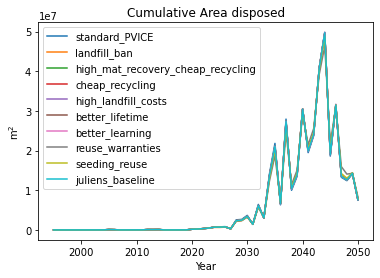

In [11]:
r1.plotScenariosComparison(keyword='Cumulative_Area_disposed')

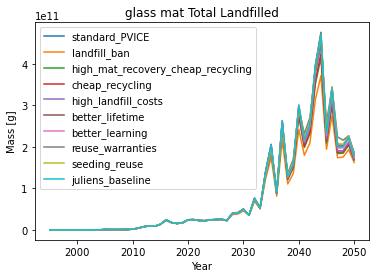

In [12]:
r1.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

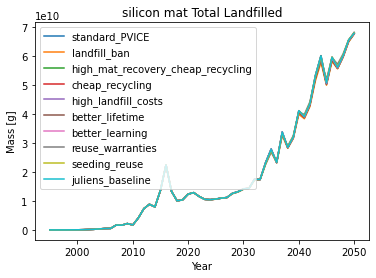

In [13]:
r1.plotMaterialComparisonAcrossScenarios(material='silicon', keyword='mat_Total_Landfilled')

In [14]:
USyearly=pd.DataFrame()

In [15]:
keyword='mat_Virgin_Stock'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["VirginStock_"+material+'_'+r1.name+'_'+case] = foo[material]
        filter_col = [col for col in USyearly if (col.startswith('VirginStock') and col.endswith(r1.name+'_'+case)) ]
        USyearly['VirginStock_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)


In [16]:
keyword='mat_Total_Landfilled'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["Waste_"+material+'_'+r1.name+'_'+case] = foo[material]
        filter_col = [col for col in USyearly if (col.startswith('Waste') and col.endswith(r1.name+'_'+case)) ]
        USyearly['Waste_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)

In [17]:
keyword='mat_Total_EOL_Landfilled'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["Waste_EOL_"+material+'_'+r1.name+'_'+case] = foo[material]
        filter_col = [col for col in USyearly if (col.startswith('Waste_EOL') and col.endswith(r1.name+'_'+case)) ]
        USyearly['Waste_EOL_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)

In [18]:
USyearly = USyearly/1000000  #Convert to metric tonnes
#907185 -- this is for US tons

In [19]:
USyearly.to_csv('ABM_Yearly_Results.csv')

### More plotting with USyearly data frame

Text(0.5, 0, 'Years')

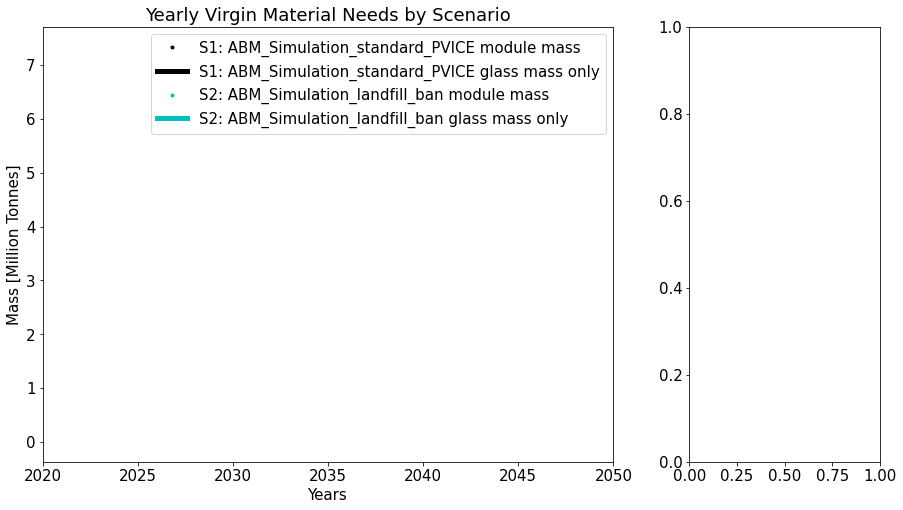

In [22]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='VirginStock_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminium_frames']


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################
   
# Loop over CASES
name0 = 'ABM_Simulation_standard_PVICE'
name2 = 'ABM_Simulation_landfill_ban'


# SCENARIO 1 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name0]+USyearly[keyw+materials[1]+'_'+name0]+
            USyearly[keyw+materials[2]+'_'+name0]+USyearly[keyw+materials[3]+'_'+name0]+
            USyearly[keyw+materials[4]+'_'+name0])
glassmat = (USyearly[keyw+materials[0]+'_'+name0])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'k.', linewidth=5, label='S1: '+name0+' module mass')
a0.plot(USyearly.index, glassmat, 'k', linewidth=5, label='S1: '+name0+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name2]+USyearly[keyw+materials[1]+'_'+name2]+
            USyearly[keyw+materials[2]+'_'+name2]+USyearly[keyw+materials[3]+'_'+name2]+
            USyearly[keyw+materials[4]+'_'+name2])
glassmat = (USyearly[keyw+materials[0]+'_'+name2])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'c.', linewidth=5, label='S2: '+name2+' module mass')
a0.plot(USyearly.index, glassmat, 'c', linewidth=5, label='S2: '+name2+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly Virgin Material Needs by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')
a0.set_xlim([2020, 2050])
a0.set_xlabel('Years')

##hm, why is this not plotting anything?

In [20]:
USyearly

,VirginStock_glass_ABM_Simulation_standard_PVICE,VirginStock_Module_ABM_Simulation_standard_PVICE,VirginStock_aluminium_frames_ABM_Simulation_standard_PVICE,VirginStock_silicon_ABM_Simulation_standard_PVICE,VirginStock_silver_ABM_Simulation_standard_PVICE,VirginStock_copper_ABM_Simulation_standard_PVICE,VirginStock_glass_ABM_Simulation_landfill_ban,VirginStock_Module_ABM_Simulation_landfill_ban,VirginStock_aluminium_frames_ABM_Simulation_landfill_ban,VirginStock_silicon_ABM_Simulation_landfill_ban,...,Waste_EOL_aluminium_frames_ABM_Simulation_seeding_reuse,Waste_EOL_silicon_ABM_Simulation_seeding_reuse,Waste_EOL_silver_ABM_Simulation_seeding_reuse,Waste_EOL_copper_ABM_Simulation_seeding_reuse,Waste_EOL_glass_ABM_Simulation_juliens_baseline,Waste_EOL_Module_ABM_Simulation_juliens_baseline,Waste_EOL_aluminium_frames_ABM_Simulation_juliens_baseline,Waste_EOL_silicon_ABM_Simulation_juliens_baseline,Waste_EOL_silver_ABM_Simulation_juliens_baseline,Waste_EOL_copper_ABM_Simulation_juliens_baseline
0,8.588168e+02,6.087252e+03,312.916411,173.147230,10.735207,0.590784,8.588168e+02,6.087252e+03,312.916411,173.147230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,6.537602e+02,4.602693e+03,232.517891,129.221067,7.853611,0.449724,6.537602e+02,4.602693e+03,232.517891,129.221067,...,0.002581,0.000720,0.000075,0.000005,0.006705,4.616548e-02,0.002581,0.000720,0.000075,0.000005
2,7.749354e+02,5.329884e+03,246.620884,150.108906,8.931884,0.532907,7.749354e+02,5.329884e+03,246.620884,150.108906,...,0.048482,0.013522,0.001415,0.000087,0.126057,8.676987e-01,0.048482,0.013522,0.001415,0.000087
3,7.747104e+02,5.260064e+03,231.966777,147.002794,8.551998,0.532939,7.747104e+02,5.260064e+03,231.966777,147.002794,...,0.287354,0.080173,0.008376,0.000514,0.748617,5.150283e+00,0.287354,0.080173,0.008376,0.000514
4,1.095228e+03,7.393424e+03,320.734477,203.492186,11.556799,0.753571,1.095228e+03,7.393424e+03,320.734477,203.492186,...,1.026034,0.286348,0.029880,0.001839,2.677158,1.841057e+01,1.026034,0.286348,0.029880,0.001839
5,1.339206e+03,8.981335e+03,384.135612,243.529034,8.626585,0.921667,1.339206e+03,8.981335e+03,384.135612,243.529034,...,2.740693,0.765066,0.079761,0.004917,7.159300,4.921891e+01,2.740693,0.765066,0.079761,0.004917
6,1.767201e+03,1.179067e+04,497.167061,314.372312,10.832734,1.215639,1.767201e+03,1.179067e+04,497.167061,314.372312,...,6.062468,1.692795,0.176356,0.010888,15.851863,1.089512e+02,6.062468,1.692795,0.176356,0.010888
7,2.658388e+03,1.764972e+04,734.455362,462.399348,15.467028,1.825065,2.658388e+03,1.764972e+04,734.455362,462.399348,...,11.713944,3.272038,0.340673,0.021058,30.659262,2.106706e+02,11.713944,3.272038,0.340673,0.021058
8,3.706166e+03,2.451234e+04,1012.037942,629.999002,20.408053,2.546397,3.706166e+03,2.451234e+04,1012.037942,629.999002,...,20.353005,5.688309,0.591876,0.036631,53.333323,3.663639e+02,20.353005,5.688309,0.591876,0.036631
9,5.826322e+03,3.832948e+04,1548.487597,979.795300,30.266716,4.005670,5.826322e+03,3.832948e+04,1548.487597,979.795300,...,32.279287,9.029057,0.938803,0.058187,84.717476,5.817275e+02,32.279287,9.029057,0.938803,0.058187
